# Import Libraries

In [26]:
import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Load and Process Data

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Convert to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)
test_images = torch.tensor(test_images, dtype=torch.float32).to(device)

In [28]:
# # Visualize dataset
# plt.figure(figsize=(6,4))
# for i in range(8):
#     plt.subplot(2,5,i+1)
#     plt.imshow(train_images[i].cpu().numpy(), cmap='gray')
#     plt.axis('off')
# plt.show()

In [29]:
# Labels not needed
class FashionMNISTData(Dataset):
  def __init__(self, images):
    self.images = images / 255. # normalize

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = self.images[index]
    return image

In [30]:
# Create datasets
training = FashionMNISTData(train_images)
testing = FashionMNISTData(test_images)

In [31]:
# Create dataloader
train_dl = DataLoader(training, batch_size=64, shuffle=True, drop_last=True)
test_dl = DataLoader(testing, batch_size=64, shuffle=False, drop_last=True)

# Feedforward Neural Network AutoEncoder

In [32]:
# Encoder neural network
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()
    self.linear1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(in_features=hidden_dim, out_features=latent_dim)

  def forward(self, x):
    # shape of x: [batch_size, input_dim]
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    return x

In [33]:
# Decoder neural network
class Decoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Decoder, self).__init__()
    self.linear1 = nn.Linear(in_features=latent_dim, out_features=hidden_dim)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(in_features=hidden_dim, out_features=input_dim)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = torch.sigmoid(x)
    return x.reshape((-1, 1, 28, 28))

In [34]:
# AutoEncoder neural network
class AutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
    self.decoder = Decoder(input_dim, hidden_dim, latent_dim)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

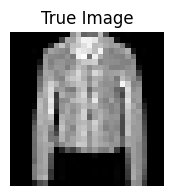

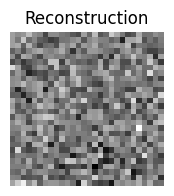

In [35]:
# Before training autoencoder
autoencoder = AutoEncoder(input_dim=784, hidden_dim=128, latent_dim=2).to(device)

true_img = testing[10].reshape((-1, 784)) # reshape to [batch_size, input_dim]
pred_img = autoencoder(true_img)

# Plot results
plt.figure(figsize=(2,2))
plt.title('True Image')
plt.axis('off')
plt.imshow(true_img.cpu().detach().numpy().reshape((28, 28)), cmap='gray')
plt.show()

plt.figure(figsize=(2,2))
plt.title('Reconstruction')
plt.axis('off')
plt.imshow(pred_img.cpu().detach().numpy().reshape((28, 28)), cmap='gray')
plt.show()

100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


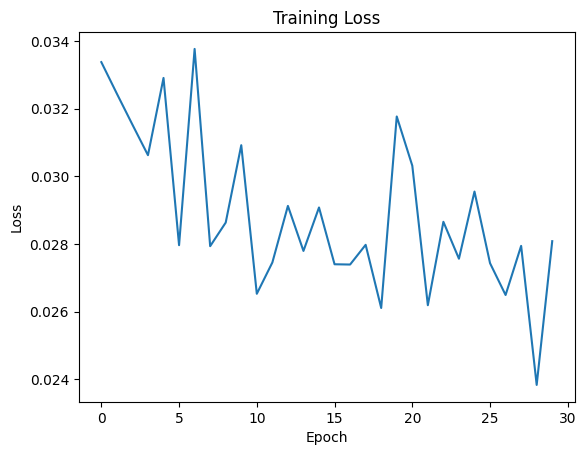

In [36]:
# Hyperparameters
input_dim = 784
hidden_dim = 128
latent_dim = 2
batch_size = 64
epochs = 30
learning_rate = 0.001

# Model
model_FNN = AutoEncoder(input_dim, hidden_dim, latent_dim).to(device)

# Loss and optimizer
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_FNN.parameters(), lr=learning_rate)

def train_model():
  # Training
  training_loss = []

  for epoch in tqdm(range(epochs)):
    for batch in train_dl:
      batch = batch.reshape(batch_size, 28*28)

      # Pass batch through model and compute loss
      reconstruction = model_FNN(batch).reshape(batch_size, 28*28)
      reconstruction_loss = loss(reconstruction, batch)

      # Update model weights
      optimizer.zero_grad()
      reconstruction_loss.backward()
      optimizer.step()

    training_loss.append(reconstruction_loss.item())

  # Plot loss
  plt.plot(training_loss)
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

train_model()

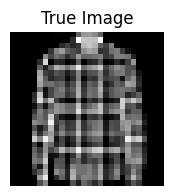

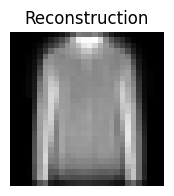

In [37]:
# Testing model after training

true_img = testing[7].reshape((-1, 784)) # select image from testing dataset
pred_img = model_FNN(true_img)

# Plot results
plt.figure(figsize=(2,2))
plt.title('True Image')
plt.axis('off')
plt.imshow(true_img.cpu().detach().numpy().reshape((28, 28)), cmap='gray')
plt.show()

plt.figure(figsize=(2,2))
plt.title('Reconstruction')
plt.axis('off')
plt.imshow(pred_img.cpu().detach().numpy().reshape((28, 28)), cmap='gray')
plt.show()

# CNN-based AutoEncoder

In [38]:
# CNN Encoder
class ConvolutionEncoder(nn.Module):
  def __init__(self):
    super(ConvolutionEncoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    return x

In [39]:
# CNN Decoder
class ConvolutionDecoder(nn.Module):
  def __init__(self):
    super(ConvolutionDecoder, self).__init__()
    self.conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
    self.relu = nn.ReLU()
    self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.sigmoid(x)
    return x

In [40]:
# CNN AutoEncoder
class ConvolutionAutoEncoder(nn.Module):
  def __init__(self):
    super(ConvolutionAutoEncoder, self).__init__()
    self.encoder = ConvolutionEncoder()
    self.decoder = ConvolutionDecoder()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

100%|██████████| 30/30 [01:06<00:00,  2.22s/it]


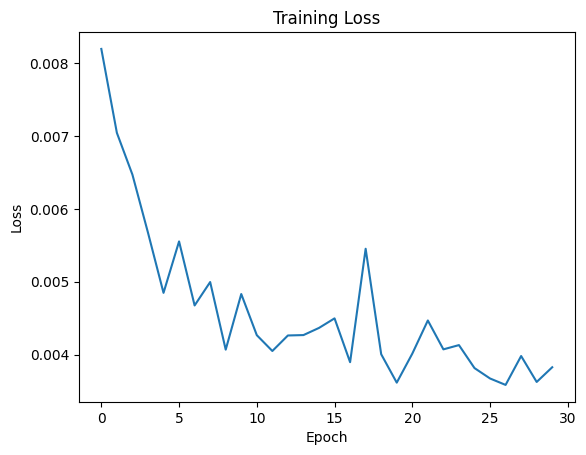

In [41]:
# Model
model_CNN = ConvolutionAutoEncoder().to(device)

# Hyperparameters
epochs = 30
batch_size = 64
learning_rate = 0.001

# Loss and optimizer
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate)

# Training
training_loss = []

for epoch in tqdm(range(epochs)):
  for batch in train_dl:
    # forward pass through model
    batch = batch.reshape(batch_size, 1, 28, 28)
    output = model_CNN(batch)
    loss_value = loss(output, batch)

    # update weights
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

  training_loss.append(loss_value.item())

# Plot loss
plt.plot(training_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

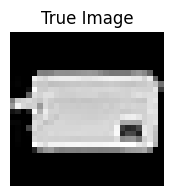

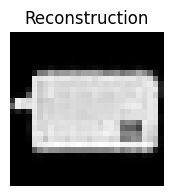

In [42]:
# Model testing
true_img = testing[58].reshape((-1, 1, 28, 28)) # select image from test dataset
pred_img = model_CNN(true_img)

# Plot results
plt.figure(figsize=(2,2))
plt.title('True Image')
plt.axis('off')
plt.imshow(true_img.cpu().detach().numpy().reshape((28, 28)), cmap='gray')
plt.show()

plt.figure(figsize=(2,2))
plt.title('Reconstruction')
plt.axis('off')
plt.imshow(pred_img.cpu().detach().numpy().reshape((28, 28)), cmap='gray')
plt.show()

# Comparing the Reconstruction Quality

In [53]:
# Feedforward Neural Network Performance Test

reconstruction_difference = 0

for true_img in testing:
  true_img = true_img.reshape(1, -1)
  pred_img = model_FNN(true_img).reshape(1, -1)
  reconstruction_difference += abs(torch.sum(true_img - pred_img).item())

mean_reconstruction_difference = reconstruction_difference / len(testing)

print('Total Reconstruction Difference: {:.2f}'.format(reconstruction_difference))
print('Mean Reconstruction Difference: {:.2f}'.format(mean_reconstruction_difference))

Total Reconstruction Difference: 81101.66
Mean Reconstruction Difference: 8.11


In [54]:
# CNN Performance Test

reconstruction_difference = 0

for true_img in testing:
  true_img = true_img.reshape((1, 1, 28, 28))
  pred_img = model_CNN(true_img)

  true_img = true_img.reshape(1, -1)
  pred_img = pred_img.reshape(1, -1)

  reconstruction_difference += abs(torch.sum(true_img - pred_img).item())

mean_reconstruction_difference = reconstruction_difference / len(testing)

print('Total Reconstruction Difference: {:.2f}'.format(reconstruction_difference))
print('Mean Reconstruction Difference: {:.2f}'.format(mean_reconstruction_difference))

Total Reconstruction Difference: 32882.54
Mean Reconstruction Difference: 3.29
